# Trabajo 1 - Análisis de redes sociales (Wiki-Vote)

### Realizado por:
* Cristina Montoya
* Shirley Bermudez
* Alexander Zuluaga

### Tabla de contenido:
1. [Contextualización de la red](#1.-Contextualización-de-la-red)
2. [Carga del archivo de datos](#2.-Carga-del-archivo-de-datos)
3. [Creación de la red dirigida](#3.-Creación-de-la-red-dirigida)
4. [Análisis de los nodos de la red](#4.-Análisis-de-los-nodos-de-la-red)
5. [Análisis de grupos cohesivos de la red](#5.-Análisis-de-grupos-cohesivos-de-la-red)

## 1. Contextualización de la red

El archivo que será analizado corresponde a las votaciones por usuarios administradores de **Wikipedia** descargado del sitio de [SNAP](https://snap.stanford.edu/data/wiki-Vote.html) (Stanford Network Analysis Project). El grupo de  administradores esta compuesto por colaboradores voluntarios de todo el mundo y tienen acceso a funciones técnicas que ayudan al mantenimiento del sistema. Cada usuario que aspira a ser administrador envía una solicitud llamada **RfA** (Request for Administrator) y a través de una discusión pública o una votación la comunidad Wikipedia decide quienes son los administradores electos.

La información objeto de análisis corresponde a la historia (desde el 3 de enero de 2008) de todas las elecciones de administradores y el historial de votos. Los datos corresponden a 2.794 elecciones con 103.663 votos en total y 7.066 usuarios electores (ya sea emitiendo o recibiendo un voto). Se obtuvieron 1.235 votaciones con elección exitosa de administrador, mientras que 1.559 no resultaron en una promoción. Aproximadamente la mitad de los votos son de administradores existentes, mientras que la otra mitad esta dada por usuarios comunes de Wikipedia.

La red contiene todos los datos de votación de **Wikipedia** desde sus inicios hasta enero de 2008. Los nodos en la red representan los usuarios del sitio y las relaciones dirigidas desde el nodo i al nodo j representan un usuario que votó por el usuario j.

## 2. Carga del archivo de datos

A continuación se realiza la importación de las diferentes **librerías** requeridas para el proceso de carga y análisis de la red de votación de Wikipedia: *pandas*, *numpy*, *matplotlib*, *networkx*, *urllib*, *pyunpack*, *os.path* y *operator* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import urllib.request
from pyunpack import Archive
import os.path
import operator
import itertools
%matplotlib inline

Descargamos el archivo de datos comprimido directamente de la página de SNAP en el formato comprimido **GZ** y realizamos la descompresión en el mismo directorio de descarga

In [2]:
archivo = "wiki-vote.txt"
if not os.path.exists(archivo):
    urllib.request.urlretrieve("https://snap.stanford.edu/data/wiki-Vote.txt.gz", archivo+".gz")
    Archive(archivo+".gz").extractall('.') #extraerlo en el mismo punto de donde lo descargamos
else:
    print("El arhivo ya se encuentra descargado!")

El arhivo ya se encuentra descargado!


Realizamos la lectura del archivo de texto con la información de la red utilizando un **DataFrame**. Luego de realizar la lectura presentamos una muestra de la información de los diferentes enlaces.

In [3]:
datos = pd.read_table(archivo,
                      delimiter = "\t",
                      header = -1,
                      names = ['FromNodeId', 'ToNodeId'],
                      skiprows = 4)

# Se presenta una muestra de 10 registros con los enlaces
datos.head(10)

,FromNodeId,ToNodeId
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478
5,3,28
6,3,30
7,3,39
8,3,54
9,3,108


Identificamos si alguna de las relaciones en la red se encuentra duplicada. Esto indicará un **factor de peso** en los diferentes enlaces y permitirá analizar niveles de influencia más halla de la conectividad entre los nodos.

In [4]:
print("Duplicated Edges: %d" % len([b for b in datos.duplicated().tolist() if b==True]))

Duplicated Edges: 0


Generamos una lista única con el ID de los nodos de la red antes de cargarla al grafo, es decir, unimos en una sola lista los valores de todos los nodos en las dos columnas **FromNodeId** y **ToNodeId**. Igualmente, generamos una nueva lista con los pares de tuplas de los enlaces del conjunto de datos.

In [5]:
N = sorted(list(set(datos['FromNodeId'].tolist() + datos['ToNodeId'].tolist())))
E = list(zip(datos['FromNodeId'], datos['ToNodeId']))

## 3. Creación de la red dirigida

Realizamos la creación de la *Red Dirigida* para el ejercicio utilizando la lista de **nodos** *N* y el listado de tuplas con los **enlaces** *E* de la red. Se imprime la cantidad de nodos y enlaces de la red.

In [6]:
G = nx.DiGraph(name="Wiki-Vote")
#Adiciono al grafo todos los nodos
G.add_nodes_from(N)
#Adiciono al grafo todos los enlaces
G.add_edges_from(E)

Realizamos el cálculo de algunos **estadísticos básicos** de la *Red Dirigida* para iniciar la exploración de la misma.

In [7]:
print("%s" % nx.info(G))
print("Average degree: %.6f" % float(sum([d for (n,d) in G.degree()]) / G.order()))
print("Density of network: %.6f" % float(G.number_of_edges() / (G.number_of_nodes()*(G.number_of_nodes()-1)))) #nx.density(G)
print("Number of isolates: %.d" % len(list(nx.isolates(G))))

len_max_wcc = len(max(nx.weakly_connected_components(G), key=len))
len_max_scc = len(max(nx.strongly_connected_components(G), key=len))

print("Nodes in largest WCC: %d (%.3f)" % (len_max_wcc, len_max_wcc/G.number_of_nodes()))
print("Nodes in largest SCC: %d (%.3f)" % (len_max_scc, len_max_scc/G.number_of_nodes()))

print("\nNo se puede calcular el radio, diámetro, excentricidad, centro y periféria debido al siguiente error:")
print("--> Found infinite path length because the graph is not connected <--")
#print("Ratio: %d" % nx.radius(U))
#print("Diameter: %d" % nx.diameter(G))
#print("Eccentricity: %s" % nx.eccentricity(G))
#print("Centro: %s" % nx.center(G))
#print("Periferia: %s" % nx.periphery(G))

Name: Wiki-Vote
Type: DiGraph
Number of nodes: 7115
Number of edges: 103689
Average in degree:  14.5733
Average out degree:  14.5733
Average degree: 29.146592
Density of network: 0.002049
Number of isolates: 0
Nodes in largest WCC: 7066 (0.993)
Nodes in largest SCC: 1300 (0.183)

No se puede calcular el radio, diámetro, excentricidad, centro y periféria debido al siguiente error:
--> Found infinite path length because the graph is not connected <--


Presentamos una **vista gráfica** de la *Red Dirigida* de las votaciones de Wikipedia a manera informativa.

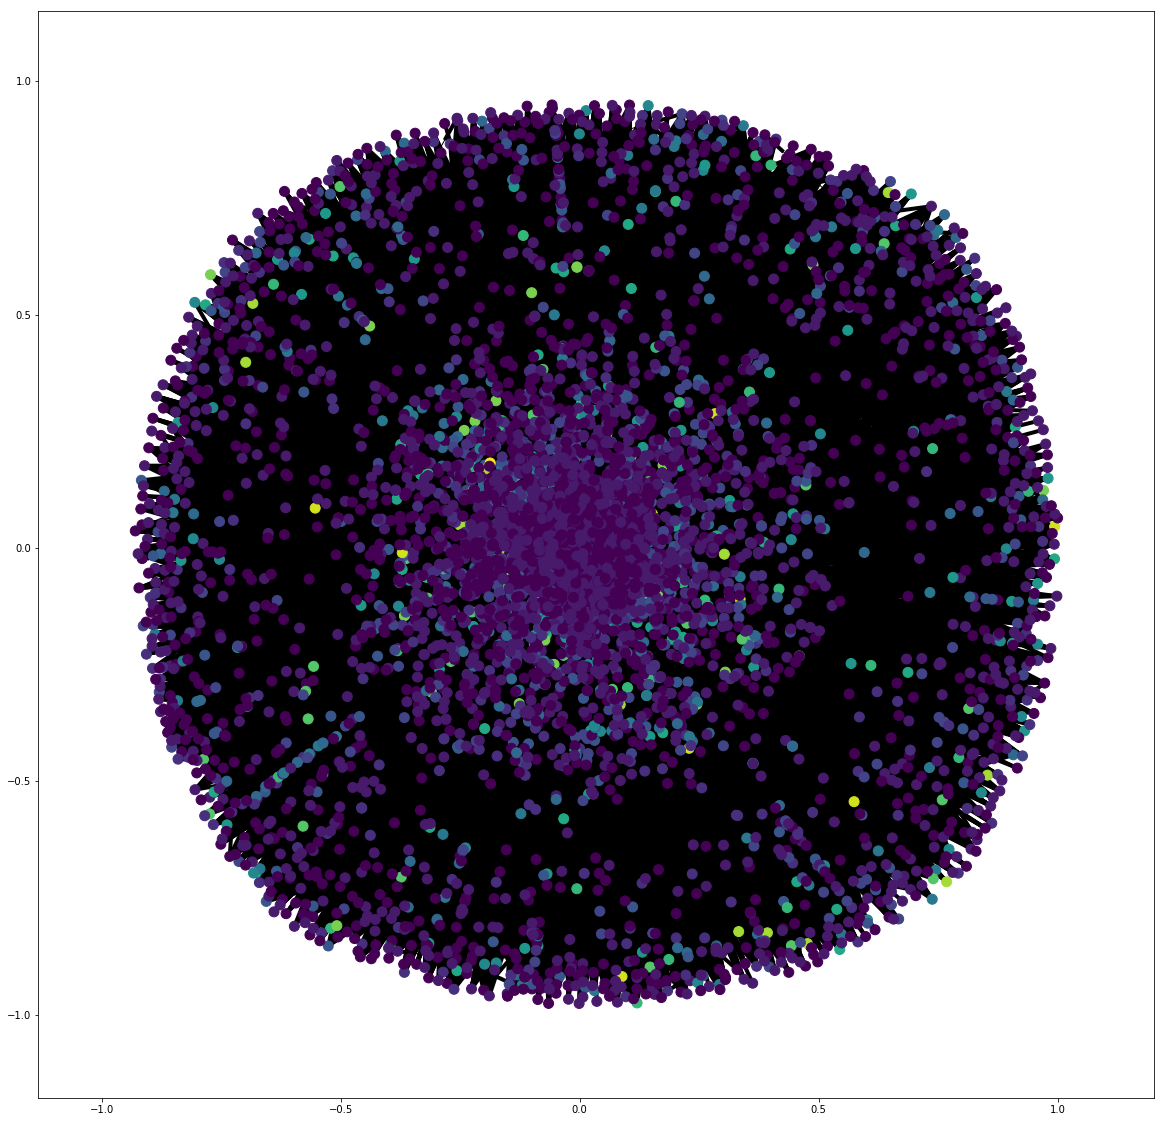

In [8]:
gcol = nx.coloring.greedy_color(G, strategy='largest_first')
cols = [float(c) for (n,c) in list(gcol.items())]
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=False, node_size=100, alpha=1, node_color=cols)

## 4. Análisis de los nodos de la red

En el siguiente histograma se presenta la **distribución de los grados** a nivel de nodo de la red, para los *enlaces de entrada*. Esta información permitirá identificar si la cantidad de votos por usuario j esta concentrada en determinados valores o más distribuida alrededor de la media.

Average in Degree: 14.573296
Variance in Degree: 1006.712091
Std Dev in Degree: 31.728727


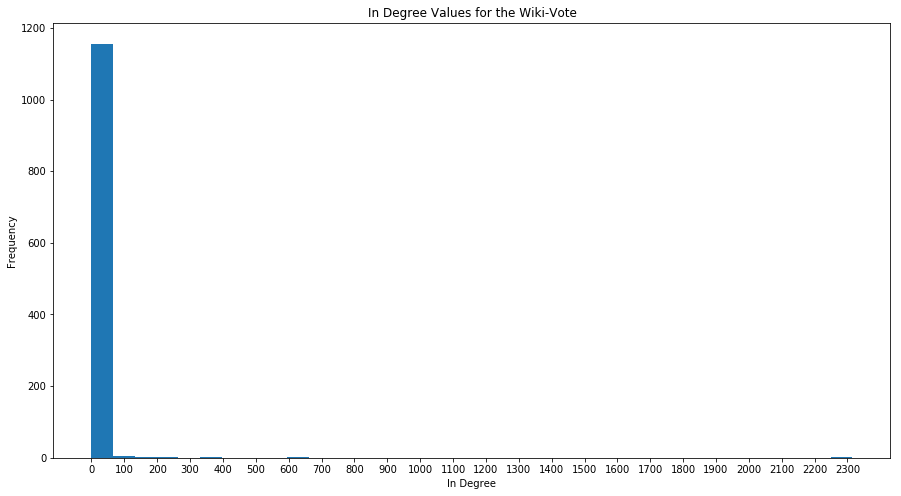

In [9]:
#Calculo de los grados de entrada para cada nodo
degrees = G.in_degree()

#Calculo de la media para los grados de entrada con base en la formula de Wasserman - Faust:
sum_of_edges = sum([d for (n,d) in degrees])
avg_deg = float(sum_of_edges / G.order())
print("Average in Degree: %.6f" % avg_deg)

#Calculo de la varianza para los grados de entrada con base en la formula de Wasserman - Faust:
sum_of_edges_var = sum([(d - avg_deg)**2 for (n,d) in degrees])
var_deg = float(sum_of_edges_var / G.order())
print("Variance in Degree: %.6f" % var_deg)

#Calculo de la desviación estándar:
print("Std Dev in Degree: %.6f" % np.sqrt(var_deg))

#Generación de histograma correspondiente a los grados de entrada:
degrees_hist = nx.degree_histogram(G)

plt.figure(figsize=(15, 8))
plt.hist(degrees_hist, bins=35)
plt.title("In Degree Values for the Wiki-Vote")
plt.xlabel("In Degree")
plt.ylabel("Frequency")
plt.xticks(np.arange(min(degrees_hist), max(degrees_hist)+1, 100.0))
plt.show()

### Análisis de centralidad de los nodos

Identificación del top 10 de usuarios con la mejor **centralidad de grado entrante** (prominentes/importantes)

In [10]:
in_degree_cent = nx.in_degree_centrality(G)
all_in_degree_cent = sorted(in_degree_cent.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame([(n,d) for (n,d) in all_in_degree_cent[0:10:]], columns=['Node', 'Rating'])

,Node,Rating
0,4037,0.064240
1,15,0.050745
2,2398,0.047793
3,2625,0.046528
4,1297,0.043435
5,2565,0.038516
6,762,0.038234
7,2328,0.037391
8,5254,0.037250
9,3352,0.037110


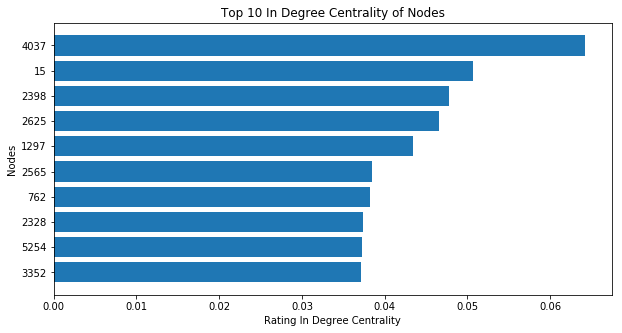

In [11]:
list_of_nodes = tuple([n for (n,d) in all_in_degree_cent[0:10:]])
list_of_degree = [d for (n,d) in all_in_degree_cent[0:10:]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_nodes)), list_of_degree, align='center')
ax.set_yticks(np.arange(len(list_of_nodes)))
ax.set_yticklabels(list_of_nodes)
ax.invert_yaxis()
ax.set_xlabel('Rating In Degree Centrality')
ax.set_ylabel('Nodes')
ax.set_title('Top 10 In Degree Centrality of Nodes')
plt.show()

Identificación del top 10 de usuarios con la mejor **centralidad de grado saliente** (influyentes)

In [12]:
out_degree_cent = nx.out_degree_centrality(G)
all_out_degree_cent = sorted(out_degree_cent.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame([(n,d) for (n,d) in all_out_degree_cent[0:10:]], columns=['Node', 'Rating'])

,Node,Rating
0,2565,0.125527
1,766,0.108659
2,11,0.104442
3,457,0.102896
4,2688,0.086871
5,1166,0.084200
6,1549,0.082513
7,1151,0.066348
8,1374,0.064942
9,1133,0.056087


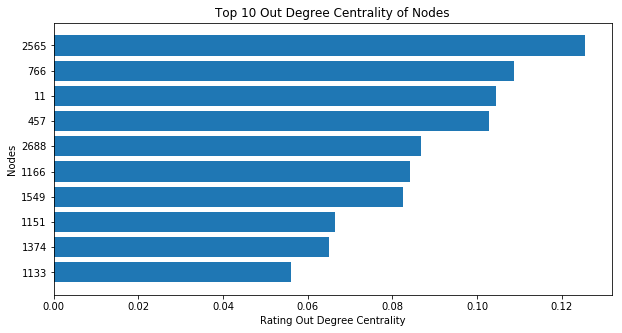

In [13]:
list_of_nodes = tuple([n for (n,d) in all_out_degree_cent[0:10:]])
list_of_degree = [d for (n,d) in all_out_degree_cent[0:10:]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_nodes)), list_of_degree, align='center')#, color='green', ecolor='black')
ax.set_yticks(np.arange(len(list_of_nodes)))
ax.set_yticklabels(list_of_nodes)
ax.invert_yaxis()
ax.set_xlabel('Rating Out Degree Centrality')
ax.set_ylabel('Nodes')
ax.set_title('Top 10 Out Degree Centrality of Nodes')
plt.show()

Identificar el top 10 de usuarios con la mejor **centralidad de cercanía** (prestigio/influencia en la red)

In [14]:
closeness_cent = nx.closeness_centrality(G, wf_improved=True)
all_close_cent = sorted(closeness_cent.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame([(n,d) for (n,d) in all_close_cent[0:10:]], columns=['Node', 'Rating'])

,Node,Rating
0,4037,0.296483
1,15,0.291490
2,2398,0.290922
3,1549,0.281927
4,2535,0.279901
5,3089,0.278048
6,762,0.278007
7,5412,0.277818
8,2565,0.277614
9,5254,0.276567


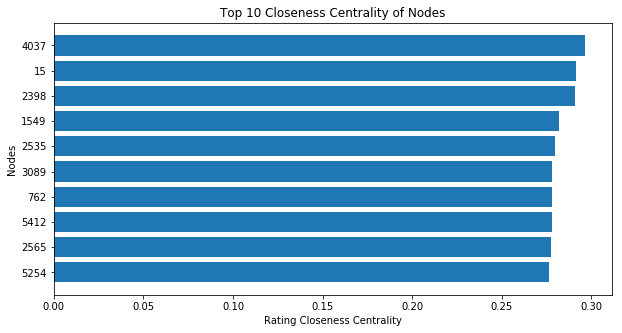

In [15]:
list_of_nodes = tuple([n for (n,d) in all_close_cent[0:10:]])
list_of_close = [d for (n,d) in all_close_cent[0:10:]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_nodes)), list_of_close, align='center')
ax.set_yticks(np.arange(len(list_of_nodes)))
ax.set_yticklabels(list_of_nodes)
ax.invert_yaxis()
ax.set_xlabel('Rating Closeness Centrality')
ax.set_ylabel('Nodes')
ax.set_title('Top 10 Closeness Centrality of Nodes')
plt.show()

Identificar el top 10 de usuarios con la mejor **centralidad de intermediación** (comunicación entre actores)

In [16]:
betweeness_cent = nx.betweenness_centrality(G, normalized=True)
all_between_cent = sorted(betweeness_cent.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame([(n,d) for (n,d) in all_between_cent[0:10:]], columns=['Node', 'Rating'])

,Node,Rating
0,2565,0.017654
1,1549,0.016564
2,15,0.011563
3,72,0.008012
4,737,0.006135
5,1166,0.005803
6,5079,0.005438
7,2328,0.005202
8,2237,0.004715
9,28,0.004564


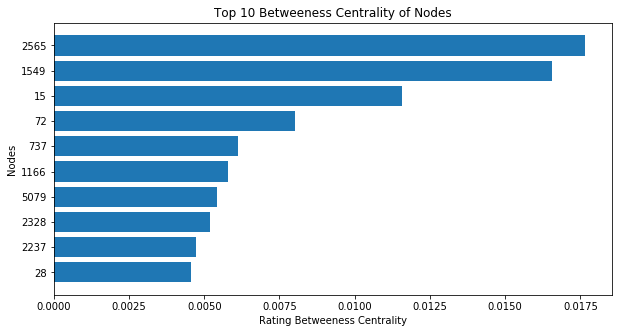

In [17]:
list_of_nodes = tuple([n for (n,d) in all_between_cent[0:10:]])
list_of_between = [d for (n,d) in all_between_cent[0:10:]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_nodes)), list_of_between, align='center')
ax.set_yticks(np.arange(len(list_of_nodes)))
ax.set_yticklabels(list_of_nodes)
ax.invert_yaxis()
ax.set_xlabel('Rating Betweeness Centrality')
ax.set_ylabel('Nodes')
ax.set_title('Top 10 Betweeness Centrality of Nodes')
plt.show()

Identificar el top 10 de usuarios con la mejor **centralidad de vector propio** (prestigio/importancia de vecinos)

In [18]:
eigen_cent = nx.eigenvector_centrality(G) 
all_eigen_cent = sorted(eigen_cent.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame([(n,d) for (n,d) in all_eigen_cent[0:10:]], columns=['Node', 'Rating'])

,Node,Rating
0,2398,0.117198
1,4037,0.108955
2,15,0.098179
3,4191,0.095690
4,2625,0.095526
5,1549,0.095032
6,2328,0.094837
7,3089,0.093107
8,5412,0.090508
9,2066,0.090484


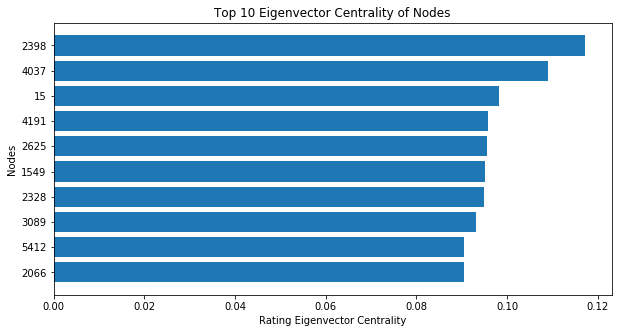

In [19]:
list_of_nodes = tuple([n for (n,d) in all_eigen_cent[0:10:]])
list_of_eigen = [d for (n,d) in all_eigen_cent[0:10:]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_nodes)), list_of_eigen, align='center')
ax.set_yticks(np.arange(len(list_of_nodes)))
ax.set_yticklabels(list_of_nodes)
ax.invert_yaxis()
ax.set_xlabel('Rating Eigenvector Centrality')
ax.set_ylabel('Nodes')
ax.set_title('Top 10 Eigenvector Centrality of Nodes')
plt.show()

El algoritmo de **PageRank** es la base de la técnica de clasificación de páginas dentro del motor de búsqueda de Google. Representa la probabilidad de que un usuario aleatorio que sigue los enlaces (por ejemplo, navegar por la web) llegue a una página en particular. Las puntuaciones de PageRank oscilan entre 0 y 1.

##### NO APORTA EN EL ANÁLISIS

In [20]:
pagerank = nx.pagerank(G)
all_pagerank = sorted(pagerank.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame([(n,d) for (n,d) in all_pagerank[0:10:]], columns=['Node', 'Rating'])

,Node,Rating
0,4037,0.004613
1,15,0.003681
2,6634,0.003525
3,2625,0.003286
4,2398,0.002605
5,2470,0.002530
6,2237,0.002505
7,4191,0.002266
8,7553,0.002170
9,5254,0.002150


A continuación se realizará una tabla consolidando los diferentes **nodos e índices** identificados en cada top 10 dados por la centralidad de grado, cercanía, intermediación y vector propio. No se incluye PageRank dado que no aporta en el análisis.

In [39]:
#Identificación del nodo más representativo de la red: NO APLICA
all_top_10 = [n for (n,d) in all_in_degree_cent[0:10:]]
all_top_10 = all_top_10 + [n for (n,d) in all_out_degree_cent[0:10:]]
all_top_10 = all_top_10 + [n for (n,d) in all_close_cent[0:10:]]
all_top_10 = all_top_10 + [n for (n,d) in all_between_cent[0:10:]]
all_top_10 = all_top_10 + [n for (n,d) in all_eigen_cent[0:10:]]

list_of_better = list(set(all_top_10))
print(list_of_better)

#new_list = list(set(list_of_most_import))
#matrix_of_occur = np.zeros([len(new_list),2])
#for index in range(len(new_list)):
#    counter = 0
#    for node in list_of_most_import:
#        if(new_list[index] == node): counter += 1
#    matrix_of_occur[index][0] = new_list[index]
#    matrix_of_occur[index][1] = counter

#matrix_of_occur = sorted(matrix_of_occur, key=lambda a_entry: a_entry[1], reverse=True)
#node_max_occur = int(matrix_of_occur[0][0])
#list_of_better = [int(elem[0]) for elem in matrix_of_occur if elem[1] > 1]
#print(list_of_better)

[2688, 2565, 5254, 11, 1549, 1166, 15, 1297, 3089, 2066, 3352, 2328, 28, 5412, 2237, 2625, 4037, 72, 457, 5079, 1374, 2398, 4191, 737, 2535, 1133, 762, 766, 1151]


In [23]:
edges_of_better = []
for i in list_of_better:
    edges_of_better = edges_of_better + [(n,i) for n in list(G.predecessors(i)) if n in list_of_better]
    edges_of_better = edges_of_better + [(i,n) for n in list(G.successors(i)) if n in list_of_better]
Gn = nx.DiGraph()
Gn.add_nodes_from(list_of_better)
Gn.add_edges_from(edges_of_better)

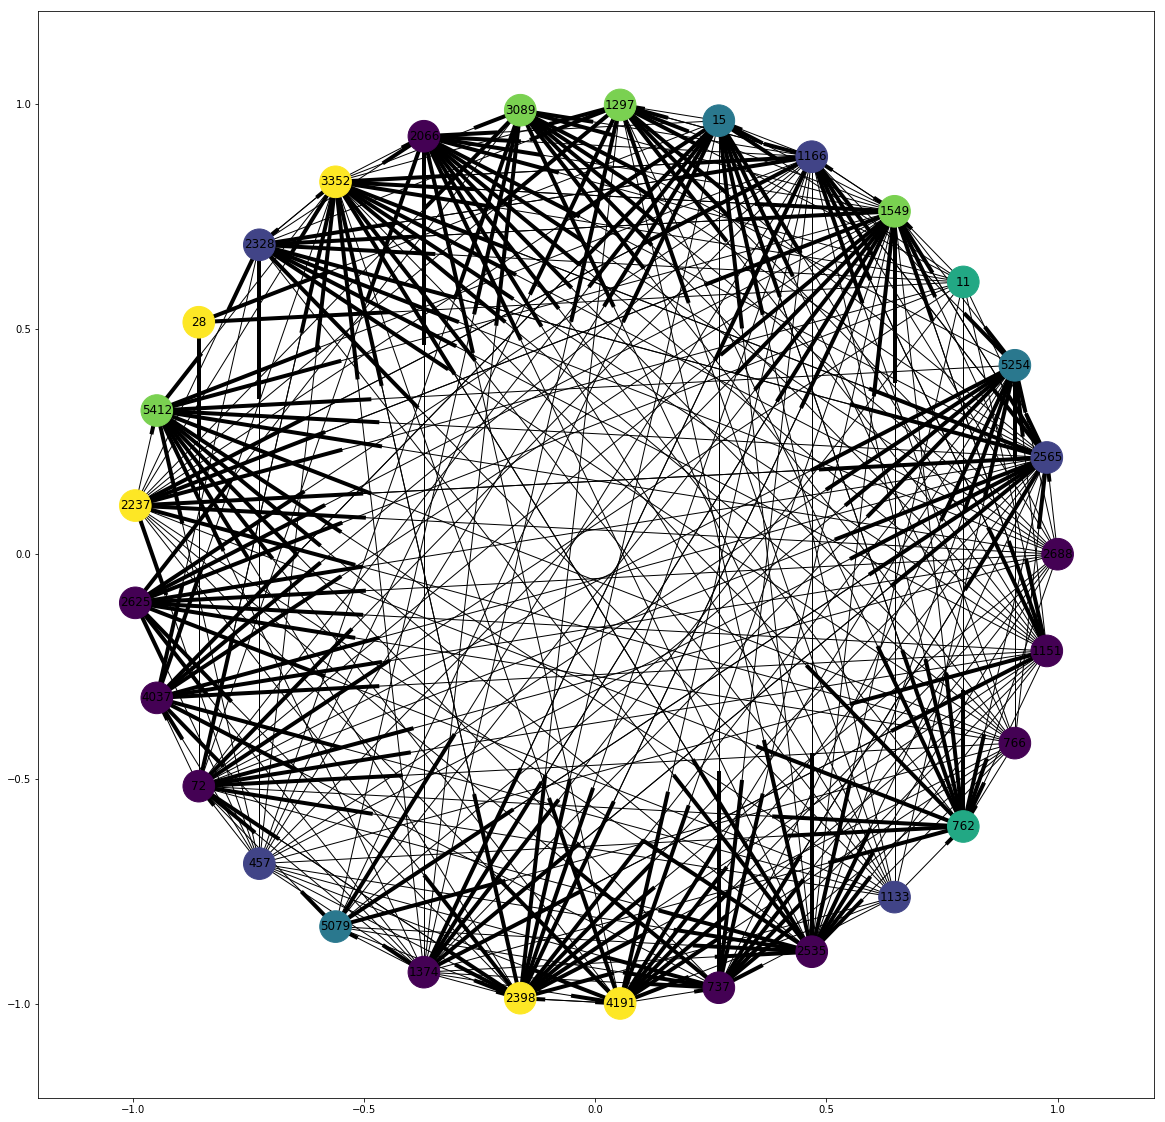

In [24]:
#Gráfico de los nodos más representativos en los análisis de centralidad
gcol = nx.coloring.greedy_color(Gn, strategy='largest_first')
cols = [float(c) for (n,c) in list(gcol.items())]
plt.figure(figsize=(20, 20))
pos = nx.shell_layout(Gn)
nx.draw_networkx(Gn, pos, with_labels=True, node_size=1000, alpha=1, node_color=cols)

In [43]:
Un = Gn.to_undirected()
print("Average clustering coef: %.6f" % nx.average_clustering(Un))

Average clustering coef: 0.669393


## 5. Análisis de grupos cohesivos de la red

A continuación se esturiaran subgrafos y clusters de la red. Los **subgrupos cohesivos** son áreas con alta densidad de nodos. La importancia de identificar subgrupos cohesivos es que estos son posibles grupos sociales en la red.

### Análisis del coeficiente de agrupamiento

El **coeficiente de agrupamiento** corresponde a la proporción de vecinos de un nodo que también son vecinos entre sí. Cuando se presentan agrupamientos en este tipo de red se podría estimar la cercanía entre estos. Para el ejercicio se analizará **agrupamiento local** y se indicará una conclusión para el agrupamiento global ya que no aporta mucho en este ejercicio.

In [25]:
#Calculo del coeficiente promedio de agrupamiento de toda la red:
U = G.to_undirected() # Se convierte a grafo no dirigido para calcular el coeficiente
print("Average clustering coef: %.6f" % nx.average_clustering(U))

Average clustering coef: 0.140898


Sample Better Nodes
2066, 5412, 3089, 3352, 1297, 2535, 4191, 2237, 5079, 2328, 762, 2625, 2398, 72, 28, 5254, 1549, 737, 1151, 2688, 1166, 1133, 1374, 766, 15, 2565, 457, 11, 4037, 

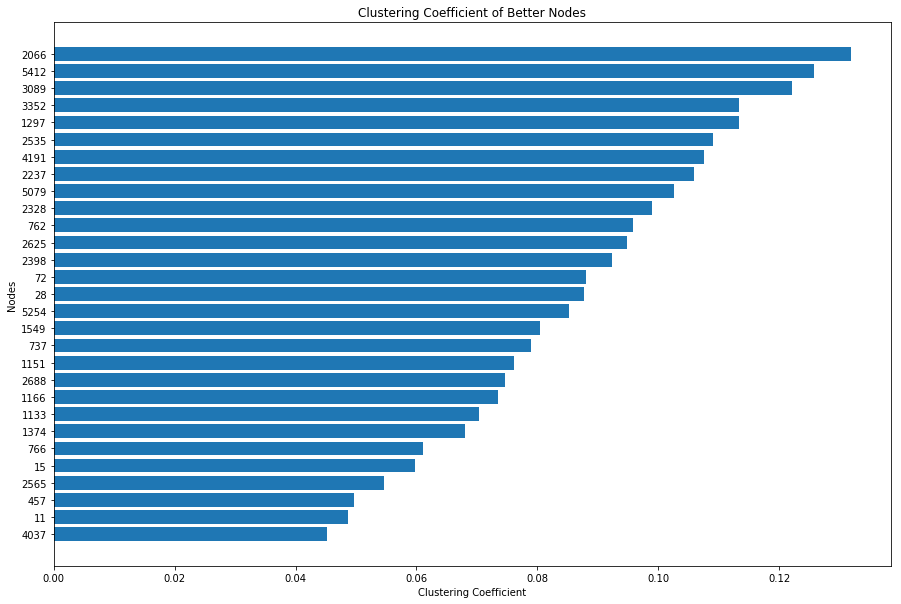

In [42]:
#Calculo de agrupamiento local para los nodos más representativos (29 nodos):
cluster_of_best = nx.clustering(U, list_of_better)
all_coef = sorted(cluster_of_best.items(), key=operator.itemgetter(1), reverse=True)
print("Sample Better Nodes")
for (n,c) in all_coef:
    print("%d" % n, end=", ")

list_of_nodes = tuple([n for (n,d) in all_coef])
coef_node = [d for (n,d) in all_coef]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_nodes)), coef_node, align='center')
ax.set_yticks(np.arange(len(list_of_nodes)))
ax.set_yticklabels(list_of_nodes)
ax.invert_yaxis()
ax.set_xlabel('Clustering Coefficient')
ax.set_ylabel('Nodes')
ax.set_title('Clustering Coefficient of Better Nodes')
plt.show()

Calculo del valor de **transitividad** en la red. Esta dado por el número de triángulos sobre número de triángulos posibles en la red.

In [27]:
print("Network Transitivity: %.6f" % nx.transitivity(G))

Network Transitivity: 0.052851


### Análisis de tríadas en la red

Calculo de las **tríadas** que se pueden presentar en la red. (Censo triádico)

In [28]:
triad_census = nx.triadic_census(G)
pd.DataFrame.from_dict(triad_census, orient='index')

,0
003,59302615490
012,669765316
102,19688797
021D,5796637
021U,3232664
021C,2746838
111D,357461
111U,558525
030T,462715
030C,6795


### Análisis del componente más fuertemente conectado en la red

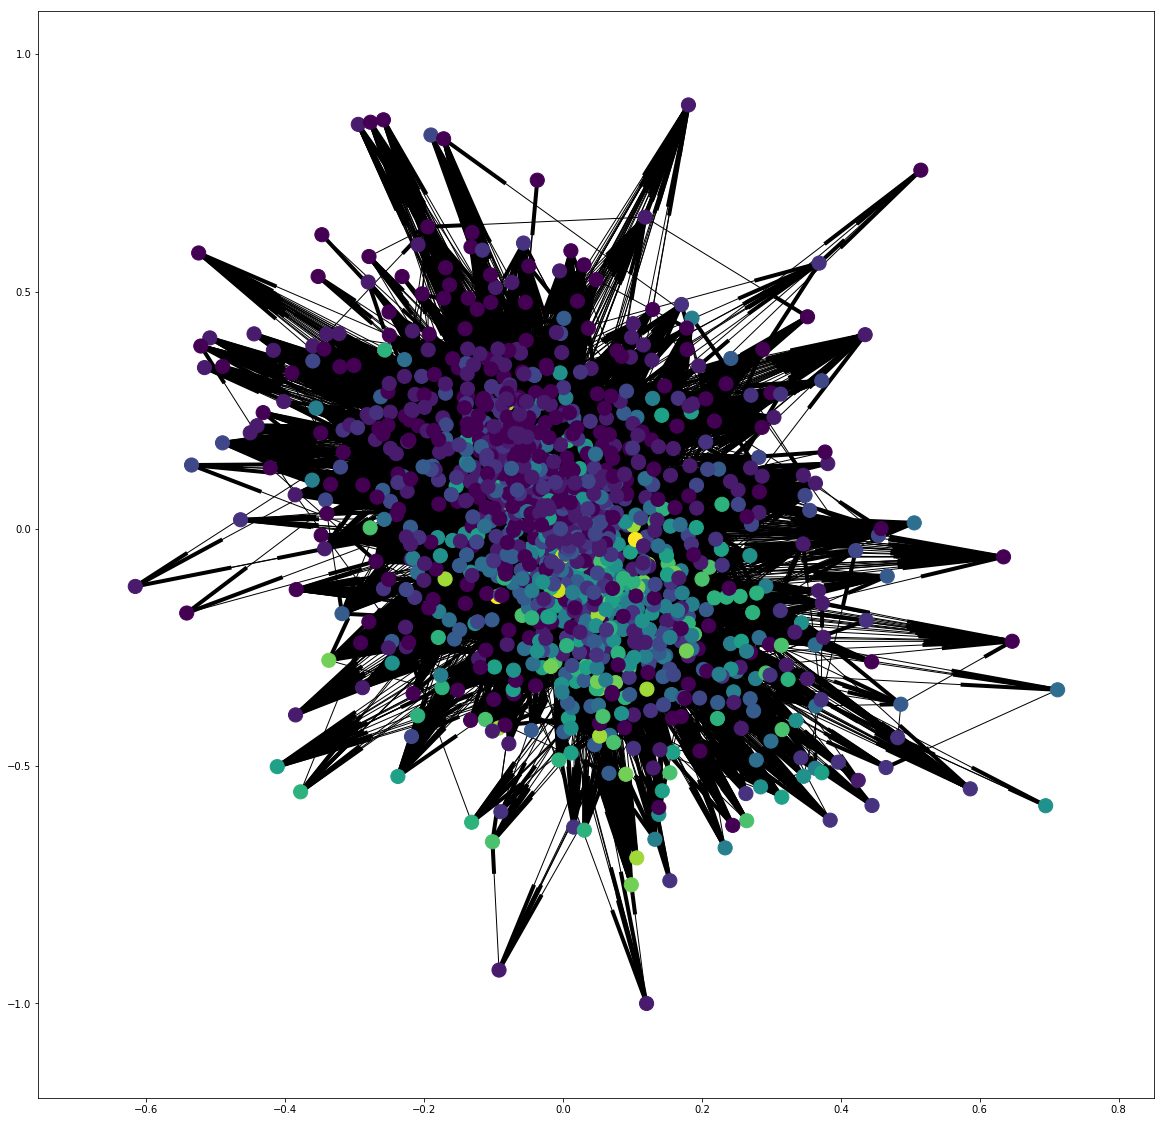

In [29]:
Gc = max(nx.strongly_connected_component_subgraphs(G), key=len)
gcol = nx.coloring.greedy_color(Gc, strategy='largest_first')
cols = [float(c) for (n,c) in list(gcol.items())]
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(Gc)
nx.draw_networkx(Gc, pos, with_labels=False, node_size=200, alpha=1, node_color=cols)

In [30]:
Uc = Gc.to_undirected()
print("Average clustering coef SCC: %.6f" % nx.average_clustering(Uc))

Average clustering coef SCC: 0.296550


In [31]:
print("SCC Transitivity: %.6f" % nx.transitivity(Gc))

SCC Transitivity: 0.085122


In [32]:
triad_census_c = nx.triadic_census(Gc)
pd.DataFrame.from_dict(triad_census_c, orient='index')

,0
003,321561264
012,37232579
102,3128763
021D,1354445
021U,484223
021C,777168
111D,149851
111U,351207
030T,154181
030C,6795


### Análisis de los K-Cores en la red

In [33]:
all_cores = nx.core_number(G)
sorted_cores = sorted(all_cores.items(), key=operator.itemgetter(1), reverse=True)
k_core = sorted_cores[0][1]
print("Best K-Core number: %d" % k_core)

#Top 10 K-Cores
#top10_cores = [(n,k) for (n,k) in sorted_cores[0:10:]]
#top10_cores
df_cores = pd.DataFrame(sorted_cores, columns=['Node','K-Core'])
df_cores_10 = df_cores[df_cores['K-Core'] > k_core-10]
df_cores_10_count = df_cores_10.groupby('K-Core').agg('count').sort_values(by='Node', ascending=False)
df_cores_10_count

Best K-Core number: 56


,Node
K-Core,
56,313
55,127
50,75
52,71
47,66
49,60
51,54
54,44
53,43


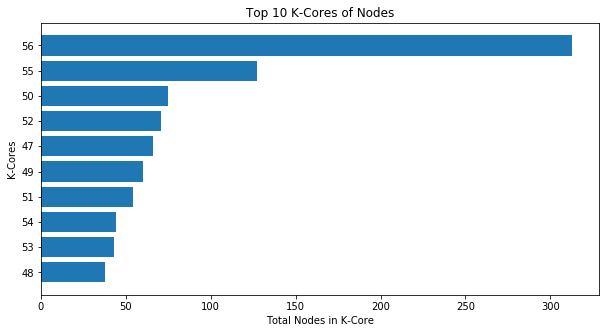

In [34]:
list_of_cores = tuple(df_cores_10_count.index.tolist())
list_of_nodes = list(np.array(df_cores_10_count.values.tolist()).flatten())

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(list_of_cores)), list_of_nodes, align='center')
ax.set_yticks(np.arange(len(list_of_cores)))
ax.set_yticklabels(list_of_cores)
ax.invert_yaxis()
ax.set_xlabel('Total Nodes in K-Core')
ax.set_ylabel('K-Cores')
ax.set_title('Top 10 K-Cores of Nodes')
plt.show()

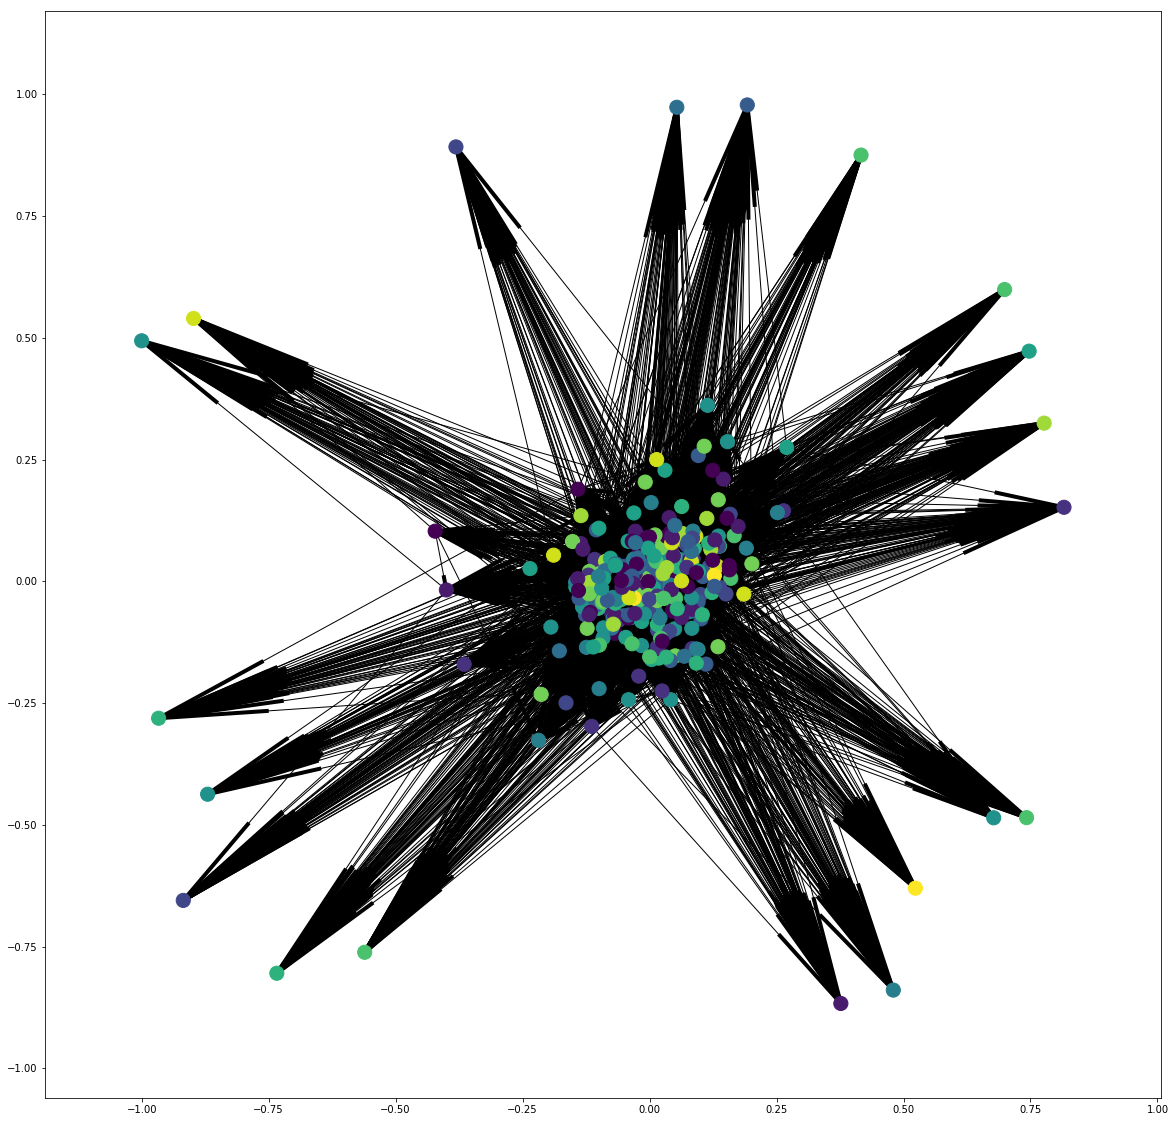

In [35]:
Gk = nx.k_core(G, k = k_core)
gcol = nx.coloring.greedy_color(Gk, strategy='largest_first')
cols = [float(c) for (n,c) in list(gcol.items())]
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(Gk)
nx.draw_networkx(Gk, pos, with_labels=False, node_size=200, alpha=1, node_color=cols)

In [36]:
Uk = Gk.to_undirected()
print("Average clustering coef Max K-Core: %.6f" % nx.average_clustering(Uk))

Average clustering coef Max K-Core: 0.406585


In [37]:
print("Max K-Core Transitivity: %.6f" % nx.transitivity(Gc))

Max K-Core Transitivity: 0.085122


In [38]:
triad_census_k = nx.triadic_census(Gk)
pd.DataFrame.from_dict(triad_census_k, orient='index')

,0
003,2119514
012,1837155
102,193867
021D,278363
021U,184409
021C,159027
111D,54069
111U,74091
030T,96799
030C,2494


PRUEBA